In [6]:
from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np

noisy_moons = datasets.make_moons(n_samples=500, noise=0.11)

In [7]:
features, labels = noisy_moons

moon_1 = features[labels==0]
moon_2 = features[labels==1]

In [8]:
print(features.shape)
print(np.unique(labels))
print(moon_1.shape)
print(moon_2.shape)

(500, 2)
[0 1]
(250, 2)
(250, 2)


# Gaussian Distribution

In [9]:
import numpy as np

def calculate_params(data):
    f1 = data[:, 0]
    f2 = data[:, 1]

    mean_1 = np.sum(f1) / len(f1)
    mean_2 = np.sum(f2) / len(f2)
    mean_matrix = np.array([mean_1, mean_2])

    cov_11 = np.sum((f1-mean_1)**2) / len(f1)
    cov_22 = np.sum((f2-mean_2)**2) / len(f2)
    cov_12 = np.sum((f1-mean_1) * (f2-mean_2)) / len(f1)

    cov_matrix = np.array([[cov_11, cov_12],
                           [cov_12, cov_22]])

    return mean_matrix, cov_matrix


def gaussian(x, mean_matrix, cov_matrix):

    det = np.linalg.det(cov_matrix)
    cov_inverse = np.linalg.inv(cov_matrix)
    diff = x - mean_matrix
    exp = np.exp(np.sum(np.dot(diff, cov_inverse) * (diff), axis=1) / -2)

    return (1 / np.sqrt((np.pi * 2) * det)) * exp

# Parameters of each moon

In [10]:
mean_moon_1, cov_moon_1 = calculate_params(moon_1)
mean_moon_2, cov_moon_2 = calculate_params(moon_2)

print("Label 0")
print("mean:", mean_moon_1)
print("covariance:", cov_moon_1)
print()
print("Label 1")
print("mean:", mean_moon_2)
print("covariance:", cov_moon_2)

Label 0
mean: [0.00125205 0.63513575]
covariance: [[0.52146235 0.0027214 ]
 [0.0027214  0.11146929]]

Label 1
mean: [ 0.997952   -0.14238946]
covariance: [[0.51051865 0.00862424]
 [0.00862424 0.11078823]]


# Plot data distribution

In [11]:
def scatter_plot(moon_1, moon_2):
    # Scatter plot for each moon
    plt.scatter(moon_1[:, 0], moon_1[:, 1], label='Label 0')
    plt.scatter(moon_2[:, 0], moon_2[:, 1], label='Label 1')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

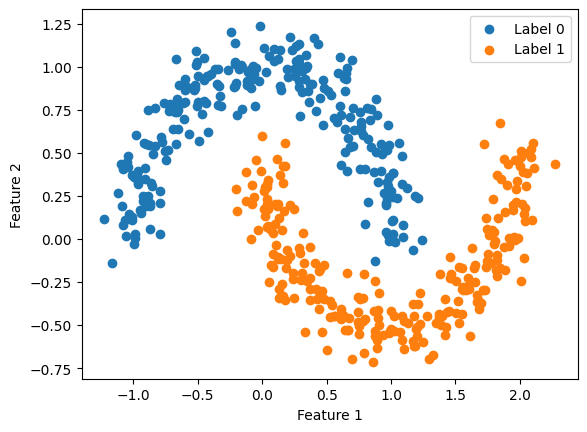

In [12]:
scatter_plot(moon_1, moon_2)

# Plot contours of each Gaussian

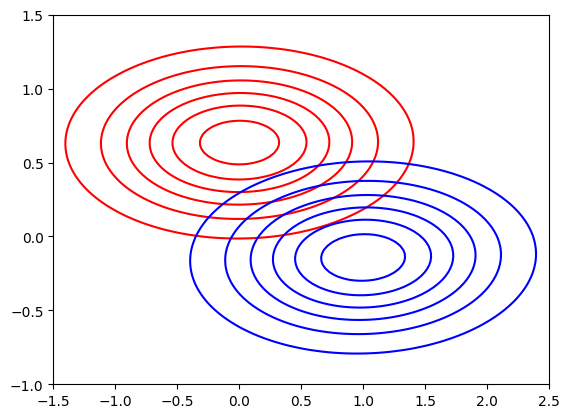

In [13]:
# Generate points for the Gaussian
x, y = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1, 1.5, 100))
points = np.c_[x.flatten(), y.flatten()]

z1 = np.array(gaussian(points, mean_moon_1, cov_moon_1) )
z1 = z1.reshape(x.shape)

z2 = np.array(gaussian(points, mean_moon_2, cov_moon_2))
z2 = z2.reshape(x.shape)

# Contour plot for the Gaussian
plt.contour(x, y, z1, colors='red')
plt.contour(x, y, z2, colors='blue')

plt.show()

# GMM

In [14]:
np.random.seed(28)

class GMM:
    def __init__(self, data, components_count, iters):
        self.components_count = components_count
        self.iters = iters
        self.data = data
        self.samples_count, self.features_count = data.shape

        # each component has a mean and covariance matrix
        # a list with length components_count, containing matrices of shape (1, features)
        self.means = [np.random.rand(data.shape[1]) for i in range(components_count)]
        self.covars = [np.eye(data.shape[1]) for i in range(components_count)]
        # also it has a probability of happening
        self.probs = [1/components_count] * components_count

    def fit(self):
        for t in range(self.iters):
            # E-step
            gaussian_all_comps = [gaussian(self.data, self.means[k], self.covars[k]) for k in range(self.components_count)]
            gamma_t = [gaussian_comp / sum(gaussian_all_comps) for gaussian_comp in gaussian_all_comps]
            gamma_t = [np.expand_dims(g, axis=1) for g in gamma_t]

            # M-step
            for k in range(self.components_count):
                numerator = np.sum(gamma_t[k] * self.data, axis=0)
                denominator = np.sum(gamma_t[k], axis=0)
                self.means[k] = numerator / denominator

                diff = self.data - self.means[k]
                self.covars[k] = np.dot(np.squeeze(gamma_t[k]) * diff.T, diff) / np.sum(gamma_t[k], axis=0)

                self.probs[k] = np.sum(gamma_t[k], axis=0) / self.samples_count

            # check convergence
            gamma_t_np = np.array(gamma_t).squeeze().T
            if np.linalg.norm(self.probs - gamma_t_np.sum(axis=0) / self.samples_count) < 1e-3:
                break

    def predict(self, x_test):
        p = np.zeros((x_test.shape[0], self.components_count))
        for k in range(self.components_count):
            p[:, k] = self.probs[k] * gaussian(x_test, self.means[k], self.covars[k])

        predictions = np.argmax(p, axis=1)
        return predictions

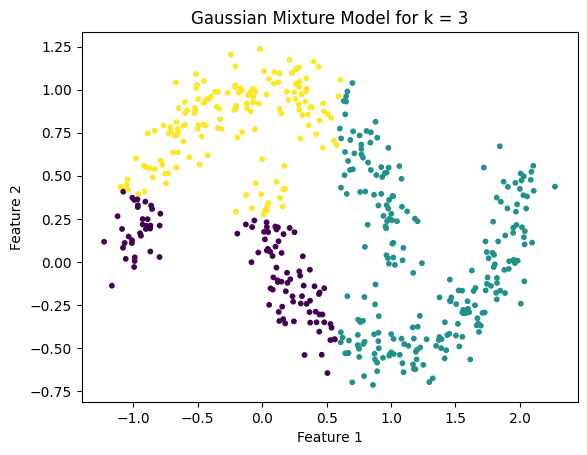

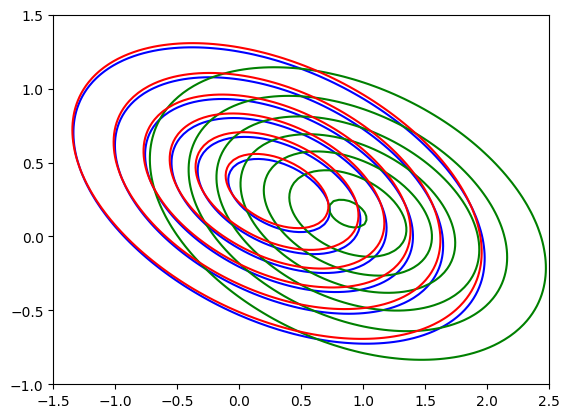

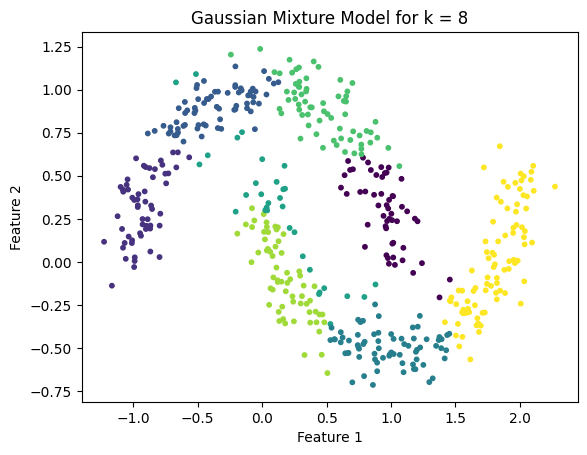

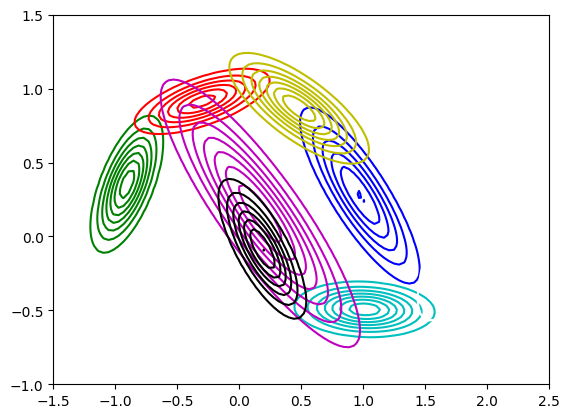

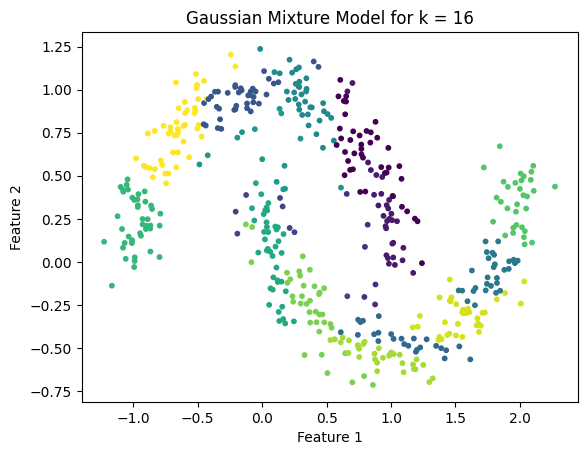

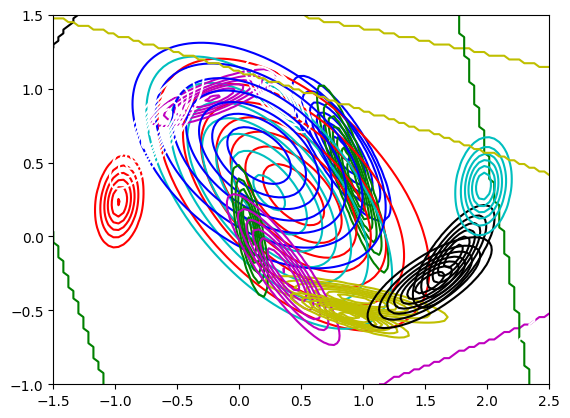

In [15]:
for i in range(1, 17):
    gmm_classifier = GMM(features, i, 100)
    gmm_classifier.fit()
    predictions = gmm_classifier.predict(features)

    colors_names = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    if i == 3 or i == 8 or i == 16:
        # Plot the data points with cluster colors
        plt.scatter(features[:, 0], features[:, 1], c=predictions, cmap='viridis', s=10)
        plt.title(f'Gaussian Mixture Model for k = {i}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        x, y = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1, 1.5, 100))
        points = np.c_[x.flatten(), y.flatten()]
        for j in range(i):
            z = np.array(gaussian(points, gmm_classifier.means[j], gmm_classifier.covars[j]))
            z = z.reshape(x.shape)

            # Contour plot for the Gaussian
            plt.contour(x, y, z, colors=colors_names[j%len(colors_names)])
        plt.show()

        print()

# Compute AIC and BIC

Best AIC: 10
Best BIC: 6


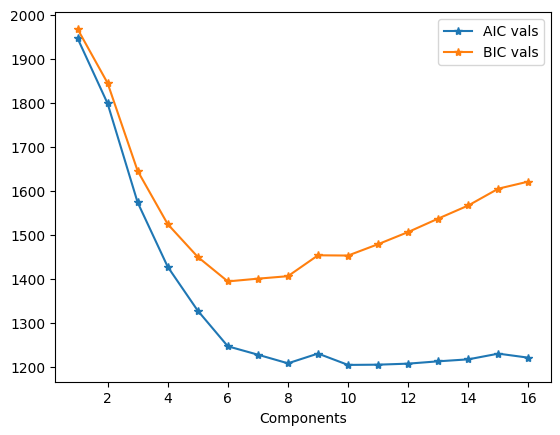

In [16]:
from sklearn.mixture import GaussianMixture

aic_vals = []
bic_vals = []
# X = noisy_moons[0]
comps = range(1, 17)
for n_components in comps:
    gmm = GaussianMixture(n_components).fit(features)
    aic_vals.append(gmm.aic(features))
    bic_vals.append(gmm.bic(features))

print(f'Best AIC: {np.argmin(aic_vals) + 1}')
print(f'Best BIC: {np.argmin(bic_vals) + 1}')

plt.plot(comps, aic_vals, '-*')
plt.plot(comps, bic_vals, '-*')
plt.xlabel('Components')
plt.legend(['AIC vals', 'BIC vals'])
plt.show()